# AlexNet


Try to show, a random initialized network, alexnet, will output things close to expected values;

For example, use alexnet-based ctrlnet for coefficient alpha;

In numerical experiments, `alpha=0.5` is good; Then initialized ctrlnet should always produce `alpha \approx 0.5` for any input. However, it has full potential to produce any results during training, with smooth/stable changing.


AlexNet(x) --> y
+ remap

Fixed input + random for k times;

See if remapped is N(0,I)

In [1]:
from pathlib import Path
from pprint import pformat,pprint

p = Path("/mnt/d/onedrive/OneDrive_cityu/OneDrive - City University of Hong Kong - Student/workspace/Dataset/DenoiseToy/data/test/clean/29026.jpg")
plist = Path("/mnt/d/onedrive/OneDrive_cityu/OneDrive - City University of Hong Kong - Student/workspace/Dataset/DenoiseToy/data/test/clean").glob("*.jpg")
plist= list(plist)
pprint(plist[:4])
assert p.exists(),p

[PosixPath('/mnt/d/onedrive/OneDrive_cityu/OneDrive - City University of Hong Kong - Student/workspace/Dataset/DenoiseToy/data/test/clean/29026.jpg'),
 PosixPath('/mnt/d/onedrive/OneDrive_cityu/OneDrive - City University of Hong Kong - Student/workspace/Dataset/DenoiseToy/data/test/clean/29027.jpg'),
 PosixPath('/mnt/d/onedrive/OneDrive_cityu/OneDrive - City University of Hong Kong - Student/workspace/Dataset/DenoiseToy/data/test/clean/29028.jpg'),
 PosixPath('/mnt/d/onedrive/OneDrive_cityu/OneDrive - City University of Hong Kong - Student/workspace/Dataset/DenoiseToy/data/test/clean/29029.jpg')]


PSNR(dB): the higher, the cleaner
 30dB+ acceptable, 40dB+ good
clean shape (256, 256, 3)
clean: min/max 0.0 1.0


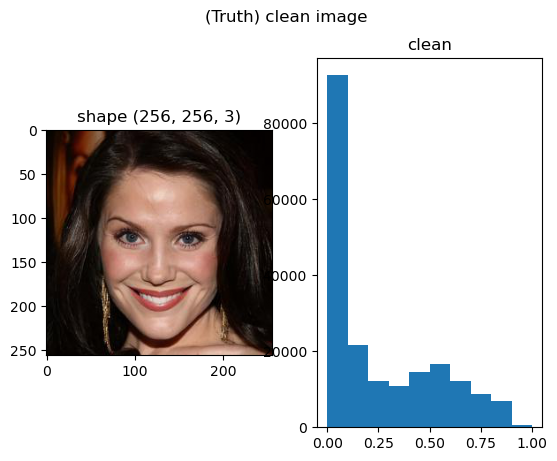

noisy: min/max -0.41354659686712464 1.2659084133594862


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


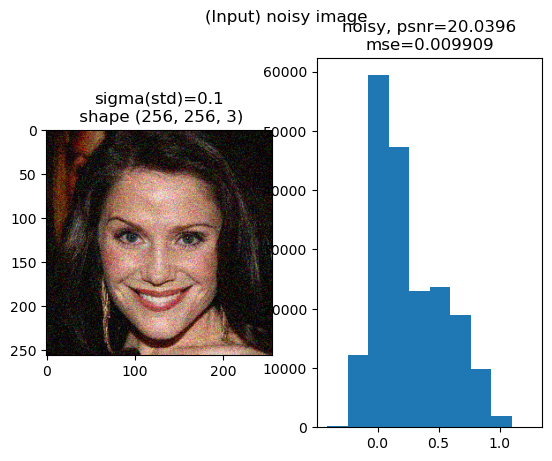

In [2]:


from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio
import torch

print("PSNR(dB): the higher, the cleaner\n 30dB+ acceptable, 40dB+ good")

def load(p,show=True):
    img = Image.open(p)
    imga = np.array(img)
    if show:
        plt.imshow(img)
        plt.show()
    return imga

clean = load(p,show=False)/255
print("clean shape", clean.shape)
print("clean: min/max", clean.min(),clean.max())
fig, axes = plt.subplots(1,2)
ax = axes[0]
ax.set_title(f"shape {clean.shape}")
ax.imshow(clean)
ax = axes[1]
ax.set_title("clean")
ax.hist(clean.flatten())
fig.suptitle('(Truth) clean image')
plt.show()

sigma = 0.1
noisy = clean + np.random.randn(*clean.shape)*sigma
psnr = peak_signal_noise_ratio(clean,noisy)
mse = torch.nn.functional.mse_loss(torch.tensor(noisy),torch.tensor(clean))
print("noisy: min/max", noisy.min(), noisy.max())
fig, axes = plt.subplots(1,2)
ax = axes[0]
ax.imshow(noisy)
ax.set_title(f"sigma(std)={sigma}\n shape {noisy.shape}")
ax = axes[1]
ax.set_title(f"noisy, psnr={psnr:.4f}\nmse={mse:.6f}")
ax.hist(noisy.flatten())
fig.suptitle('(Input) noisy image')
plt.show()

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class AlexNet(nn.Module):
    """
    BCHW --> num_classes
    """
    def __init__(self, B, C, H, W, num_classes=1000):
        super(AlexNet, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(C, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        
        # Compute the input shape of the classifier
        self.classifier_input_shape = self._compute_classifier_input_shape(B, C, H, W)
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(self.classifier_input_shape, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
    def _compute_classifier_input_shape(self, B, C, H, W):
        # Create a dummy tensor to compute the output shape of the features module
        dummy_input = torch.zeros((B, C, H, W))
        features_output = self.features(dummy_input)
        _, C, H, W = features_output.shape
        return C * H * W


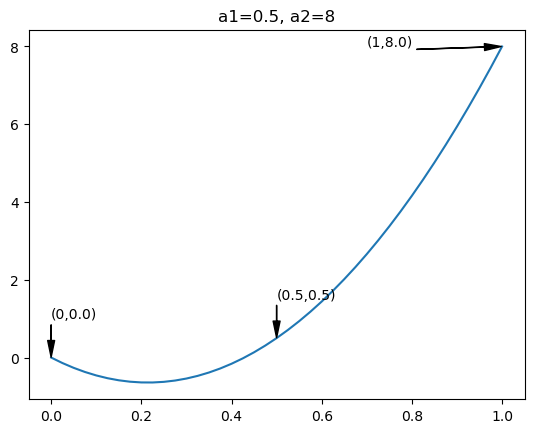

In [4]:
from torch import Tensor
def remap2(a:Tensor,a1:float,a2:float):
    """
    a is float in [0,1];
    Quadratic mapping:
    from [0,1] to [0,a2],
    curve passing:
    (0,0), (1/2,a1), (1,a2)
    y = (2 *a2- 4*a1) a^2 + (-a2 +4*a1) a
    """
    a1 = torch.ones_like(a)*a1
    a2 = torch.ones_like(a)*a2
    aa = (2* a2 - 4*a1) * a*a + (-a2 +4*a1)*a
    return aa
    
from matplotlib import pyplot as plt
import numpy as np
def show(remap,a1,a2):
    _xx = np.array(range(41))/40
    _yy = remap(torch.tensor(_xx),a1,a2)
    fig,ax = plt.subplots(1,1)
    ax.plot(_xx, _yy.numpy())
    ax.set_title(f"a1={a1}, a2={a2}")
    _yy_min = remap(torch.tensor(0),a1,a2).item()
    ax.annotate(f"(0,{_yy_min})",(0,_yy_min),(0,_yy_min+1),arrowprops=dict(facecolor='black', shrink=0.01,width=0.1,headwidth=5))
    _yy_half = remap(torch.tensor(0.5),a1,a2).item()
    ax.annotate(f"(0.5,{_yy_half})",(0.5,_yy_half),(0.5,_yy_half+1),arrowprops=dict(facecolor='black', shrink=0.01,width=0.1,headwidth=5))
    _yy_max = remap(torch.tensor(1),a1,a2).item()
    ax.annotate(f"(1,{_yy_max})",(1,_yy_max),(0.7,_yy_max),arrowprops=dict(facecolor='black', shrink=0.01,width=0.1,headwidth=5))
    plt.show()

show(remap2,0.5,8)

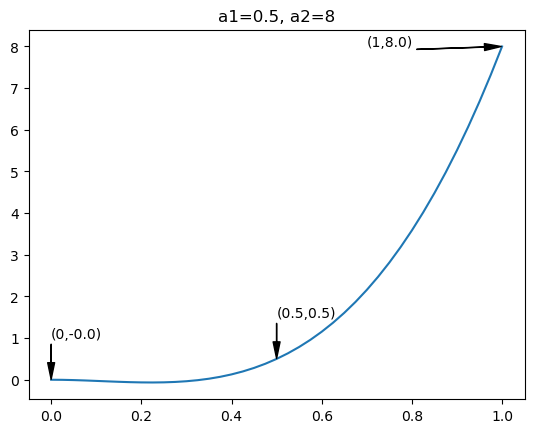

In [5]:
def remap3(x,a1,a2):
    a1=  torch.ones_like(x)*a1
    a2 = torch.ones_like(x)*a2
    y = ( (-8*a1+2*a2)*x + (8*a1 -a2))*x**2
    return y

show(remap3,0.5,8)

### Coefficient ctrlnet , alexnet
> Limit coef in [0,a2]. Expectation = a1

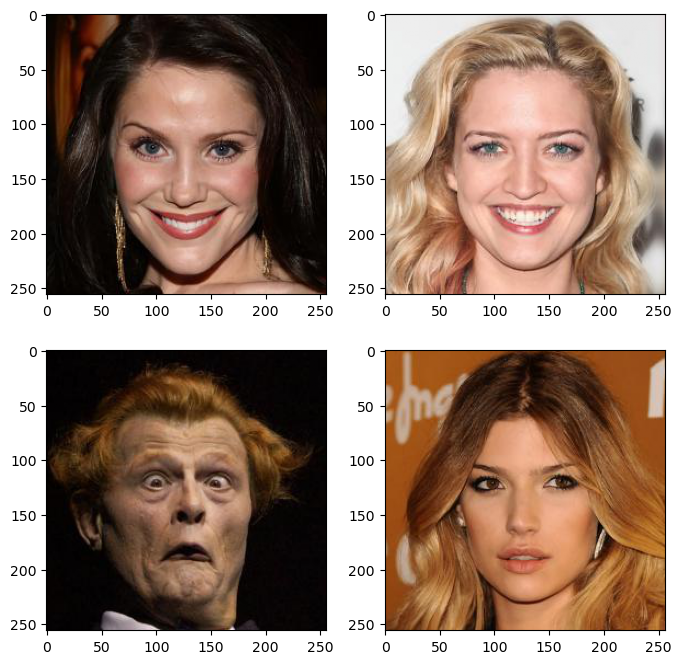

In [42]:

device = torch.device("cuda:0")
def show_imgs():
    fig,axes = plt.subplots(2,2,figsize=(8,8))
    ax= axes[0][0]
    clean = load(plist[0],False)/255
    ax.imshow(clean)
    ax= axes[0][1]
    clean = load(plist[1],False)/255
    ax.imshow(clean)
    ax= axes[1][0]
    clean = load(plist[2],False)/255
    ax.imshow(clean)
    ax= axes[1][1]
    clean = load(plist[3],False)/255
    ax.imshow(clean)
    plt.show()
    
def show_2(net):
    fig,axes = plt.subplots(2,2,figsize=(8,8))
    ax = axes[0][0]
    clean = load(plist[0],False)/255
    f = torch.tensor(clean).permute(2,0,1).unsqueeze(0).float().to(device)
    pred = net(f)
    ax.set_title(f"shape{tuple(pred.shape)},\nmin{pred.min().item():.3f},\nmax{pred.max().item():.3f},\nmean{pred.mean().item():.3f}")
    ax.hist(pred.detach().cpu().flatten().numpy(),bins=32)

    ax = axes[0][1]
    clean = load(plist[1],False)/255
    f = torch.tensor(clean).permute(2,0,1).unsqueeze(0).float().to(device)
    pred = net(f)
    ax.set_title(f"shape{tuple(pred.shape)},\nmin{pred.min().item():.3f},\nmax{pred.max().item():.3f},\nmean{pred.mean().item():.3f}")
    ax.hist(pred.detach().cpu().flatten().numpy(),bins=32)

    ax = axes[1][0]
    clean = load(plist[2],False)/255
    f = torch.tensor(clean).permute(2,0,1).unsqueeze(0).float().to(device)
    pred = net(f)
    ax.set_title(f"shape{tuple(pred.shape)},\nmin{pred.min().item():.3f},\nmax{pred.max().item():.3f},\nmean{pred.mean().item():.3f}")
    ax.hist(pred.detach().cpu().flatten().numpy(),bins=32)

    ax = axes[1][1]
    clean = load(plist[3],False)/255
    f = torch.tensor(clean).permute(2,0,1).unsqueeze(0).float().to(device)
    pred = net(f)
    ax.set_title(f"shape{tuple(pred.shape)},\nmin{pred.min().item():.3f},\nmax{pred.max().item():.3f},\nmean{pred.mean().item():.3f}")
    ax.hist(pred.detach().cpu().flatten().numpy(),bins=32)

    fig.subplots_adjust(hspace=0.6, wspace=0.6)
    plt.show()
    
show_imgs()

#### alexnet- 1000, expectation

Default output of Alexnet, for inputs[0:4] from dataset


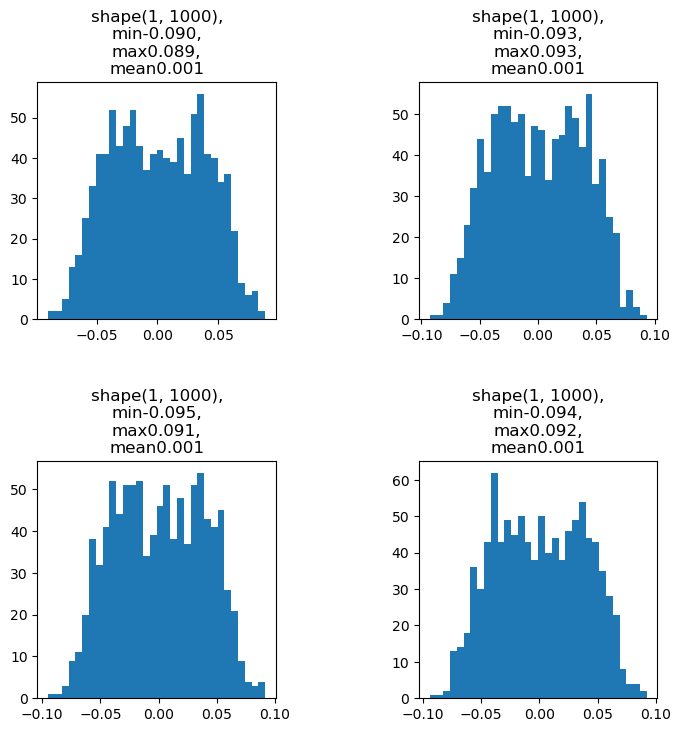

In [30]:



f = torch.tensor(clean).permute(2,0,1).unsqueeze(0).float().to(device)
B,C,H,W = f.shape
alexnet = AlexNet(B,C,H,W).to(device)
print("Default output of Alexnet, for inputs[0:4] from dataset")
show_2(alexnet)

alexnet.sigmoid


/home/tjrym/miniconda3/envs/pytorch112/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


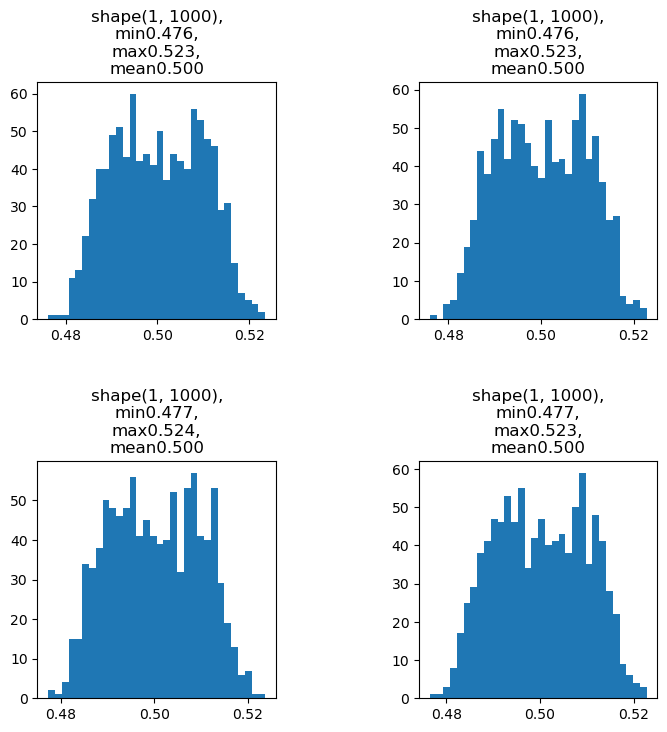

In [31]:
def alexnet_sig(f):
    pred = alexnet(f)
    predsig = F.sigmoid(pred)
    return predsig
print("alexnet.sigmoid")
show_2(alexnet_sig)
    

alexnet.sigmoid.remap3


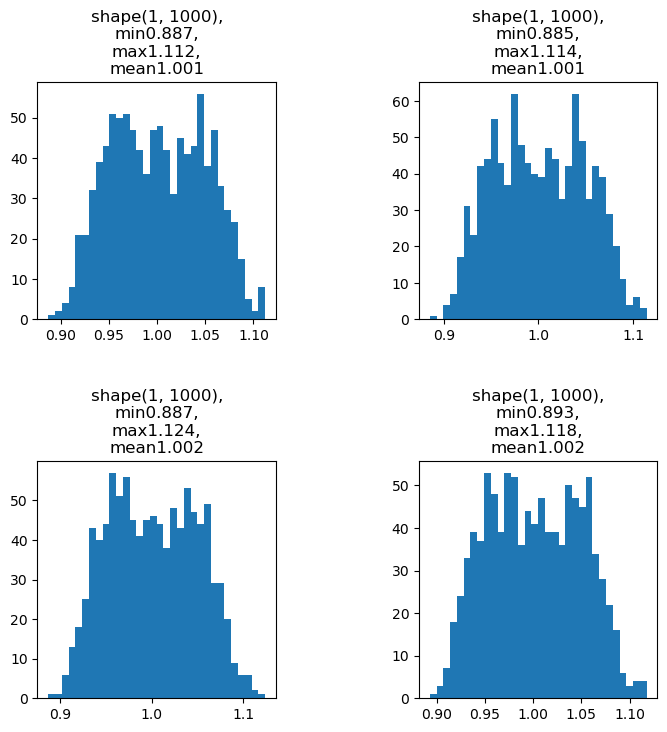

In [32]:
def alexnet_remap3(f):
    pred = alexnet(f)
    predsig = F.sigmoid(pred)
    predsr3 = remap3(predsig,1,6)
    return predsr3
print("alexnet.sigmoid.remap3")
show_2(alexnet_remap3)

#### Alexnet-1, nclass =1

Input[0:4] from dataset,
alexnet


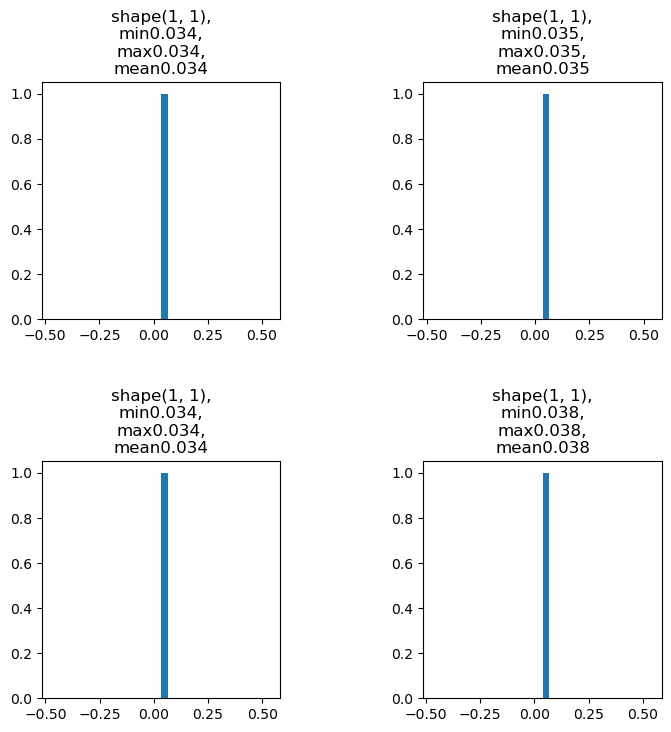

In [14]:

device = torch.device("cuda:0")
f = torch.tensor(clean).permute(2,0,1).unsqueeze(0).float().to(device)
B,C,H,W = f.shape
alexnet = AlexNet(B,C,H,W,1).to(device)
print("Input[0:4] from dataset,")
print("alexnet")
show_2(alexnet)

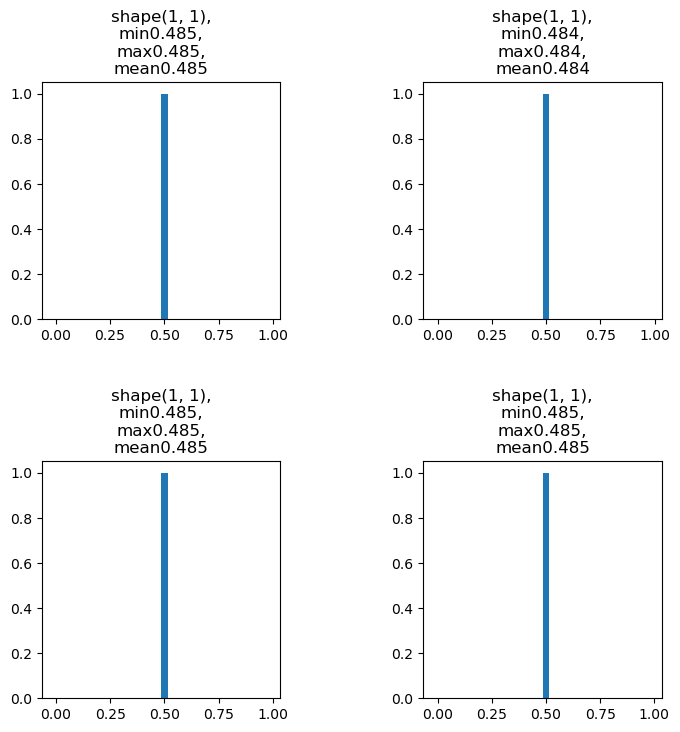

In [11]:
def alexnet_sig(f):
    pred = alexnet(f)
    predsig = F.sigmoid(pred)
    return predsig
print("alexnet.sigmoid")
show_2(alexnet_sig)
    

alexnet.sigmoid.remap3


/home/tjrym/miniconda3/envs/pytorch112/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


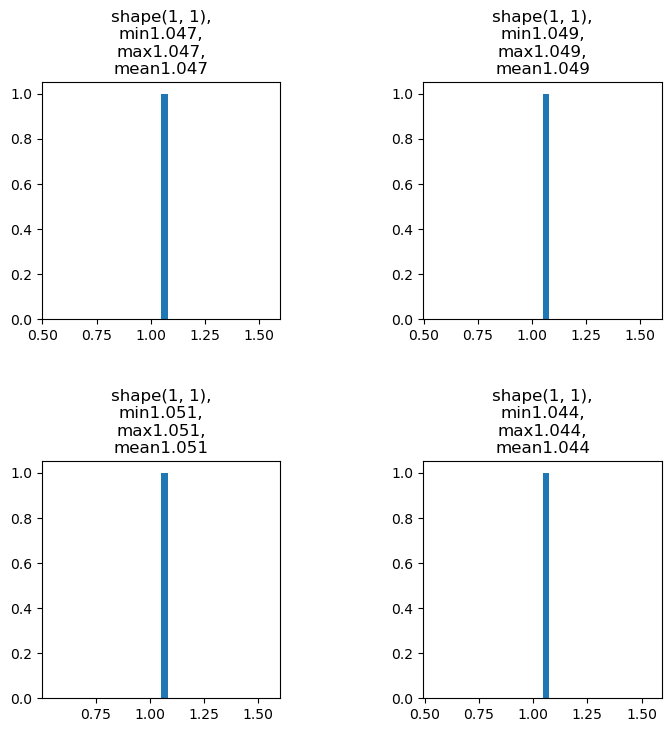

In [15]:
def alexnet_remap3(f):
    pred = alexnet(f)
    predsig = F.sigmoid(pred)
    predsr3 = remap3(predsig,1,6)
    return predsr3
print("alexnet.sigmoid.remap3")
show_2(alexnet_remap3)

Conclusion: after initialization, a alexnet outputs mean0, symmetric, distribution, with [0,1]x256x256x3 images.

looks like Uniform dist.

### Kernel control net , alexnet

In [37]:
device = torch.device("cuda:0")
kR=  2
kH = kW =(2*kR+1)
K_ref = torch.tensor([[0, 0,0,0,0],
                      [0, 0,0,0,0],
                      [0,-1,1,0,0],
                      [0, 0,0,0,0],
                      [0, 0,0,0,0]]).float()
assert K_ref.shape[0]==kH
assert K_ref.shape[1]==kW

In [43]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl
def show_3(net):
    fig,axes = plt.subplots(2,2,figsize = (8,8))
    def _draw(ax,kernel):
        im = ax.imshow(kernel.detach().cpu().numpy())
        # Rotate the tick labels and set their alignment.
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
        
        for i in range(kH):
            for j in range(kW):
                text = ax.text(j, i, f"{kernel[i, j]:.2f}",
                ha="center", va="center", color="w")
        
        _sum = kernel.sum()
        _pos = kernel[kernel>0].sum()
        ax.set_title(f"sum={_sum:.4f}, pos={_pos:.4f}")
    
    def _get(i):
        clean = load(plist[i],False)/255
        f = torch.tensor(clean).permute(2,0,1).unsqueeze(0).float().to(device)
        pred = net(f)
        kernel = pred.reshape(kH,kW)
        return kernel
        
    _draw(axes[0][0],_get(0))
    _draw(axes[0][1],_get(1))
    _draw(axes[1][0],_get(2))
    _draw(axes[1][1],_get(3))

    plt.show()
    
def show_4(net):
    
    fig,axes = plt.subplots(2,2,figsize = (8,8))
    def _draw(ax,kernel):
        pass
        



/tmp/ipykernel_30263/2481817608.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right",


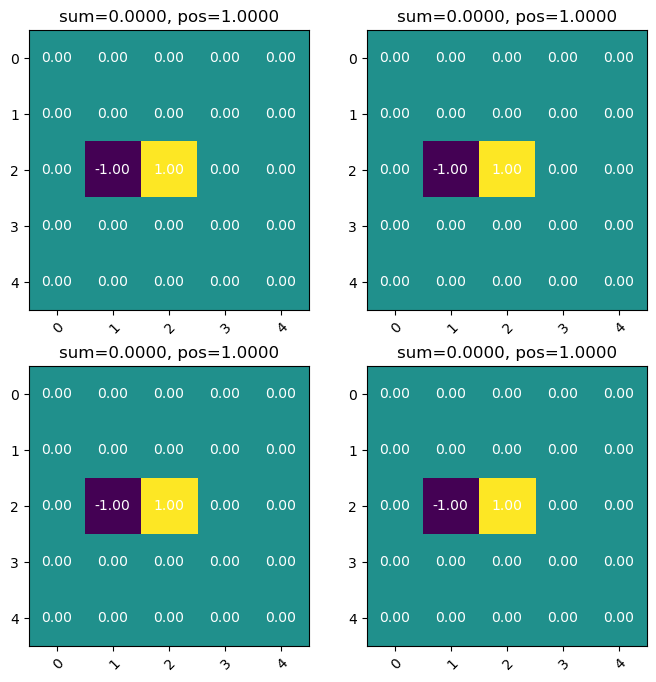

In [46]:
def kernel_ref(f):
    return K_ref

show_3(kernel_ref)

/tmp/ipykernel_30263/2481817608.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right",


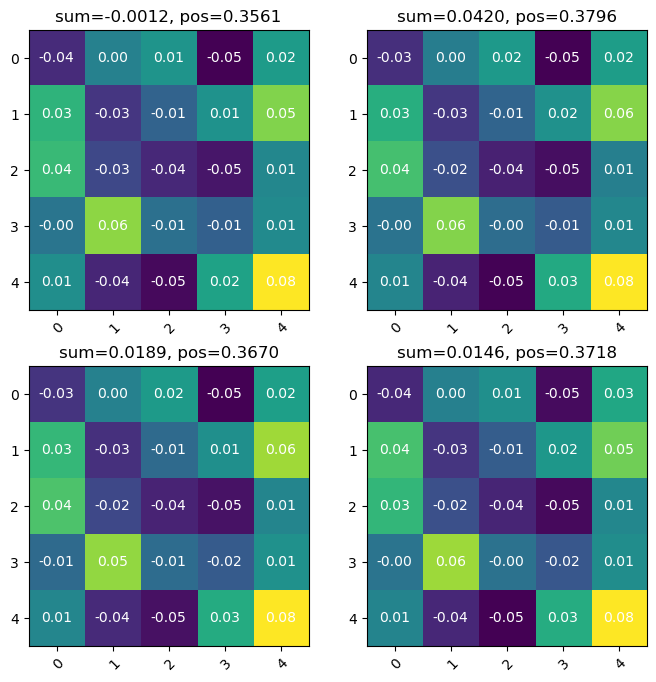

In [44]:

f = torch.tensor(clean).permute(2,0,1).unsqueeze(0).float().to(device)
B,C,H,W = f.shape
alexnet = AlexNet(B,C,H,W,kH*kW).to(device)



def kernel_alex(f):
    pred= alexnet(f)
    kernel = pred.reshape(kH,kW)
    return kernel
show_3(kernel_alex)

/tmp/ipykernel_30263/2481817608.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right",


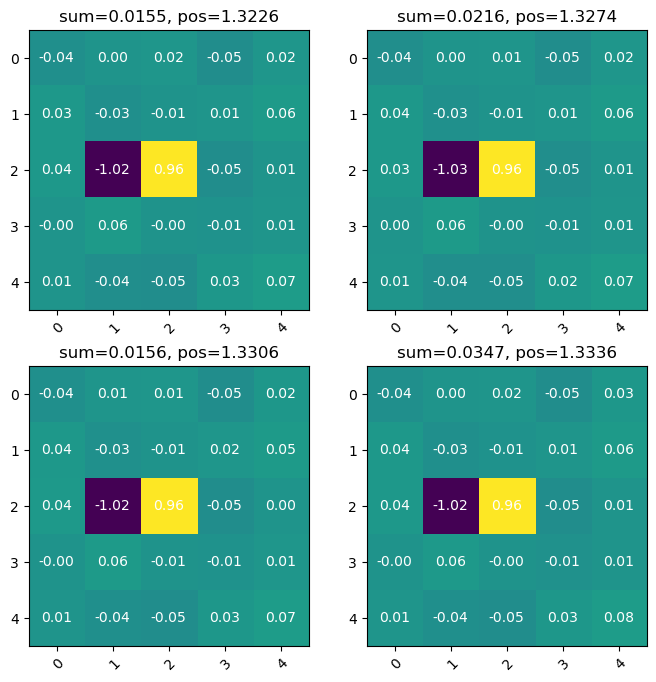

In [45]:
def kernel_alex_plus(f):
    pred= alexnet(f)
    kernel = pred.reshape(kH,kW)
    ker = kernel + K_ref.to(f.device)
    return ker

show_3(kernel_alex_plus)

/tmp/ipykernel_30263/2481817608.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right",


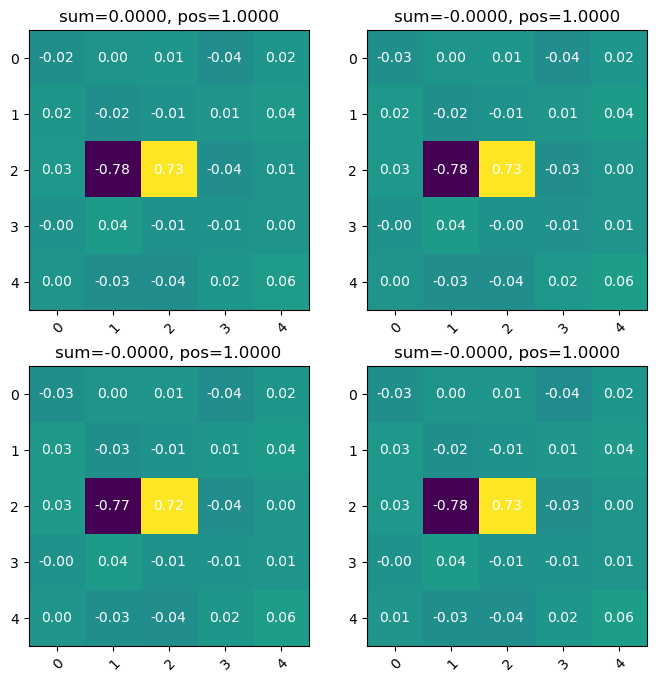

In [52]:
def remapk_sp(kernel):
    _sum = kernel.sum()/kernel.numel()
    
    _kernel = (kernel - _sum)
    
    _pos = _kernel[_kernel>0].sum()
    
    _kernel = _kernel/_pos
    
    return _kernel

def kernel_alex_plus_remapk_sp(f):
    pred= alexnet(f)
    kernel = pred.reshape(kH,kW) + K_ref.to(f.device)
    _kernel = remapk_sp(kernel)
    return _kernel

show_3(kernel_alex_plus_remapk_sp)